Using device: cuda
Reproducibility seed set: 42


Saving Pride_and_Prejudice-Jane_Austen.txt to Pride_and_Prejudice-Jane_Austen.txt
Text length: 711331
Vocab size: 64
Dataset prepared. Train size: 640152 Val size: 71129
Epoch 1 | Train Loss: 1.2351 | Val Loss: 1.0655
Epoch 2 | Train Loss: 1.1003 | Val Loss: 1.0195
Epoch 3 | Train Loss: 1.0743 | Val Loss: 0.9986
Epoch 4 | Train Loss: 1.0616 | Val Loss: 0.9876
Epoch 5 | Train Loss: 1.0533 | Val Loss: 0.9792
Epoch 6 | Train Loss: 1.0470 | Val Loss: 0.9722
Epoch 7 | Train Loss: 1.0419 | Val Loss: 0.9658
Epoch 8 | Train Loss: 1.0378 | Val Loss: 0.9622
Epoch 9 | Train Loss: 1.0344 | Val Loss: 0.9581
Epoch 10 | Train Loss: 1.0314 | Val Loss: 0.9544
Epoch 11 | Train Loss: 1.0286 | Val Loss: 0.9522
Epoch 12 | Train Loss: 1.0262 | Val Loss: 0.9490
Epoch 13 | Train Loss: 1.0239 | Val Loss: 0.9457
Epoch 14 | Train Loss: 1.0219 | Val Loss: 0.9435
Epoch 15 | Train Loss: 1.0201 | Val Loss: 0.9431


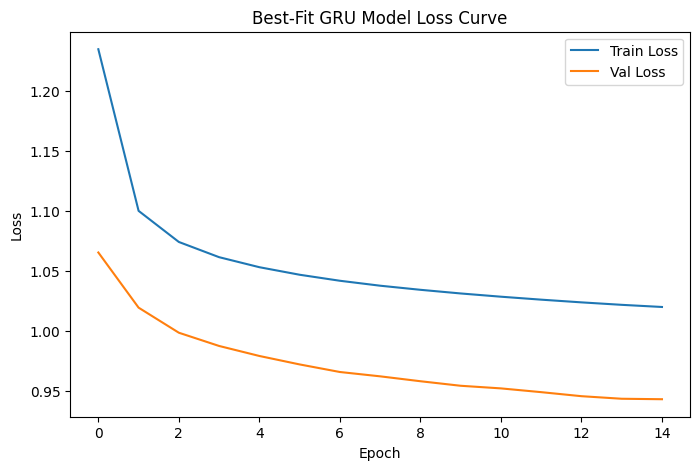

In [1]:
# ===============================
# BEST-FIT GRU LANGUAGE MODEL
# ===============================
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import random

# ======================================================
# DEVICE
# ======================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ======================================================
# REPRODUCIBILITY
# ======================================================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print("Reproducibility seed set:", SEED)

# ======================================================
# 1. LOAD DATA
# ======================================================
from google.colab import files
uploaded = files.upload()

# Replace with your uploaded file name
file_name = list(uploaded.keys())[0]
text = open(file_name, "r", encoding="utf-8").read().lower()
print("Text length:", len(text))

# ======================================================
# 2. TOKENIZATION
# ======================================================
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("Vocab size:", vocab_size)

char2idx = {ch: i for i, ch in enumerate(chars)}
idx2char = {i: ch for ch, i in char2idx.items()}
encoded = np.array([char2idx[ch] for ch in text])

# ======================================================
# 3. PREPARE DATASET
# ======================================================
SEQ_LEN = 50
BATCH_SIZE = 64

class CharDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]
        y = self.data[idx+1:idx+self.seq_len+1]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

dataset = CharDataset(encoded, SEQ_LEN)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

print("Dataset prepared. Train size:", train_size, "Val size:", val_size)

# ======================================================
# 4. GRU MODEL — BEST-FIT
# ======================================================
class GRU_LM(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, num_layers=2, dropout=0.3):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(
            embed_dim,
            hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embed(x)
        out, hidden = self.gru(x, hidden)
        logits = self.fc(out)
        return logits, hidden

model = GRU_LM(vocab_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=2
)

# ======================================================
# 5. TRAINING LOOP (WITH EARLY STOPPING)
# ======================================================
EPOCHS = 15
train_losses, val_losses = [], []
best_val = float("inf")
patience = 3
wait = 0

for epoch in range(1, EPOCHS+1):
    model.train()
    epoch_loss = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits, _ = model(x)
        loss = criterion(logits.reshape(-1, vocab_size), y.reshape(-1))
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        epoch_loss += loss.item()

    avg_train = epoch_loss / len(train_loader)
    train_losses.append(avg_train)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits, _ = model(x)
            loss = criterion(logits.reshape(-1, vocab_size), y.reshape(-1))
            val_loss += loss.item()

    avg_val = val_loss / len(val_loader)
    val_losses.append(avg_val)

    print(f"Epoch {epoch} | Train Loss: {avg_train:.4f} | Val Loss: {avg_val:.4f}")

    scheduler.step(avg_val)

    # Early stopping
    if avg_val < best_val:
        best_val = avg_val
        wait = 0
        torch.save(model.state_dict(), "best_gru_model.pth")
    else:
        wait += 1
        if wait >= patience:
            print(" Early stopping triggered!")
            break

# ======================================================
# 6. PLOT LOSSES
# ======================================================
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Best-Fit GRU Model Loss Curve")
plt.legend()
plt.show()

# ======================================================
# 7. GENERATE TEXT (OPTIONAL)
# ======================================================
def generate_text(model, start_str, length=200):
    model.eval()
    chars = [char2idx[c] for c in start_str.lower()]
    input_seq = torch.tensor(chars, dtype=torch.long).unsqueeze(0).to(device)
    hidden = None
    result = start_str

    with torch.no_grad():
        for _ in range(length):
            logits, hidden = model(input_seq, hidden)
            probs = torch.softmax(logits[:, -1, :], dim=-1)
            char_id = torch.multinomial(probs, num_samples=1).item()
            result += idx2char[char_id]
            input_seq = torch.tensor([chars[-SEQ_LEN+1:] + [char_id]], dtype=torch.long).to(device)
            chars.append(char_id)
            chars = chars[-SEQ_LEN:]

    return result

In [2]:
import math

# =============================
# FINAL PERPLEXITY CALCULATION
# =============================

def calculate_perplexity(model, dataloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            logits, _ = model(x)
            loss = criterion(logits.reshape(-1, vocab_size), y.reshape(-1))
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    ppl = math.exp(avg_loss)
    return avg_loss, ppl

# Load best saved model
best_model = GRU_LM(vocab_size).to(device)
best_model.load_state_dict(torch.load("best_gru_model.pth"))

train_loss, train_ppl = calculate_perplexity(best_model, train_loader)
val_loss, val_ppl = calculate_perplexity(best_model, val_loader)

print("=== FINAL RESULTS ===")
print(f"Train Loss: {train_loss:.4f} | Train Perplexity: {train_ppl:.4f}")
print(f"Val Loss:   {val_loss:.4f} | Val Perplexity:   {val_ppl:.4f}")

=== FINAL RESULTS ===
Train Loss: 0.9358 | Train Perplexity: 2.5493
Val Loss:   0.9431 | Val Perplexity:   2.5680
